In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from keras.utils import plot_model
from keras.layers import Conv1D, GlobalAveragePooling2D, Reshape, Layer
from keras.activations import sigmoid
from keras.saving import register_keras_serializable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.tseries.offsets import DateOffset

In [21]:
print(tf.__version__)
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU


In [22]:
# dirs
DATA_DIR = "./load.csv"

In [23]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')
data['Load'] = data['Load'] * 4


In [24]:
# scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
data['Load'] = data_scaled

In [25]:
"""
The dataset columns must be the format below:

  index             Timestamp   Load
      0   20xx-xx-xx xx:xx:xx    xxx
      1                   ...    ...
      2                   ...    ...
                                 ...

"""

'\nThe dataset columns must be the format below:\n\n  index             Timestamp   Load\n      0   20xx-xx-xx xx:xx:xx    xxx\n      1                   ...    ...\n      2                   ...    ...\n                                 ...\n\n'

In [26]:
data

,Timestamp,Load
0,2023-01-01 00:00:00,0.445492
1,2023-01-01 00:15:00,0.427049
2,2023-01-01 00:30:00,0.445492
3,2023-01-01 00:45:00,0.420902
4,2023-01-01 01:00:00,0.422951
...,...,...
35035,2023-12-31 22:45:00,0.331148
35036,2023-12-31 23:00:00,0.270492
35037,2023-12-31 23:15:00,0.365574
35038,2023-12-31 23:30:00,0.337295


In [27]:
"""
!! parameter settings
n_predict: predict steps
height: final height of the image:
            height * 2 if the n_predict <= width,
            height * 2 + 1 if the n_predict > width
width: width of the image
n_days: use past n days historical time series data as input (number of channel)
n_window_shift: the shift interval of sliding window
"""
n_predict = 12
height = 4
width = 24
n_days_b = 3
n_days_s = 3
n_window_shift = "15min"

In [28]:
class TimeSeriesImageEncoder():
    def __init__(
            self,
        X: pd.DataFrame,
        n_predict: int,
        height: int,
        width: int,
        n_days_b: int,
        n_days_s: int,
        n_window_shift: str
    ) -> None:
        self.X = X
        self.h = height
        self.m = width
        self.d_b = n_days_b
        self.d_s = n_days_s
        self.shift = n_window_shift
        self.n_predict = n_predict
        self.Lb = self.h * self.m
        self.Ls = math.ceil(self.n_predict / self.m) * self.m
        self.timestamps = self.generate_timestamps()
        print(f"Lb: {self.Lb}")
        print(f"Ls: {self.Ls}")

    def generate_timestamps(self):
        start = self.X['Timestamp'].min() + DateOffset(days=self.d_b)
        end = self.X['Timestamp'].max() - DateOffset(minutes=self.n_predict*15)
        timestamps = pd.date_range(start=start, end=end, freq=self.shift)
        return timestamps
    
    def generate_gaussian_noise(self, length, std_dev=0.15):
        noise = np.random.normal(loc=0.5, scale=std_dev, size=length)
        noise = np.clip(noise, 0, 1)
        # noise = np.zeros(shape=length)
        return pd.DataFrame({"Load": noise})
    
    def make_it_symmetric_3d(self, sets_3d):
        symmetry_training_sets = []
        for slice_2d in np.array(sets_3d):
            reversed_slice_2d = slice_2d[::-1]
            combined_slice_2d = np.concatenate((slice_2d, reversed_slice_2d), axis=0)
            symmetry_training_sets.append(combined_slice_2d)
        return np.array(symmetry_training_sets)
    
    def make_it_symmetric_2d(self, sets_2d):
        combined_slice = np.concatenate((sets_2d, sets_2d), axis=0)
        return np.array(combined_slice).reshape(2, int(len(combined_slice)/2))
    

    def encode_b(self):
        training_sets = []
        target_sets = []
        self.X_timeseries_flatten = []
        self.X_timestamp = []
        self.y_timestamp = []
        for steps in self.timestamps:
            training_start_b = steps - DateOffset(days=self.d_b-1, hours=23, minutes=45)
            training_end = steps
            target_start = training_end + DateOffset(minutes=15)
            target_end = steps + DateOffset(minutes=(self.n_predict)*15)
            # noise = self.generate_gaussian_noise(length=self.n_predict)
            training_data = self.X[(self.X['Timestamp'] >= training_start_b) & (self.X['Timestamp'] <= training_end)]
            # training_data = pd.concat([training_data, noise], ignore_index=True)
            target_data = self.X[(self.X['Timestamp'] >= target_start) & (self.X['Timestamp'] <= target_end)]
            if not training_data.empty and not target_data.empty:
                self.X_timeseries_flatten.append(training_data['Load'])
                self.X_timestamp.append(training_data['Timestamp'])
                self.y_timestamp.append(target_data['Timestamp'])
                training_reshaped = np.array(training_data['Load']).reshape(self.d_b, self.h, self.m)
                symmetric_3d = self.make_it_symmetric_3d(training_reshaped)
                training_sets.append(symmetric_3d)
                symmetric_2d = self.make_it_symmetric_2d(target_data['Load'])
                target_sets.append(symmetric_2d)
        training_sets = np.array(training_sets)
        target_sets = np.array(target_sets)

        self.X_timeseries_flatten = np.array(self.X_timeseries_flatten)
        self.X_timestamp = np.array(self.X_timestamp)
        self.y_timestamp = np.array(self.y_timestamp)
        return training_sets, target_sets
    
    def encode_s(self):
        training_sets = []
        for steps in self.timestamps:
            training_subset = []
            point = steps - DateOffset(days=self.d_s-1)
            training_start = point - DateOffset(minutes=(self.m-1)*15)
            # training
            for _ in range(self.d_s-1):
                training_end = training_start + DateOffset(minutes=(self.m-1)*15)
                training_data = self.X[(self.X['Timestamp'] >= training_start) & (self.X['Timestamp'] <= training_end)]
                if not training_data.empty:
                    symmetric_2d = self.make_it_symmetric_2d(training_data['Load'])
                    training_subset.append(symmetric_2d)
                training_start = training_start + DateOffset(days=1)
            training_end = training_start + DateOffset(minutes=(self.m-self.n_predict-1)*15)
            training_data = self.X[(self.X['Timestamp'] >= training_start) & (self.X['Timestamp'] <= training_end)]
            noise = self.generate_gaussian_noise(length=self.n_predict)
            training_data = pd.concat([training_data, noise], ignore_index=True)
            symmetric_2d = self.make_it_symmetric_2d(training_data['Load'])
            training_subset.append(symmetric_2d)
            training_sets.append(training_subset)
        training_sets = np.array(training_sets)
        return training_sets
    
    def encode(self):
        training_sets_b, target_sets = self.encode_b()
        # training_sets_s = self.encode_s()
        training_sets_b = np.transpose(training_sets_b, (0, 2, 3, 1))
        # training_sets_s = np.transpose(training_sets_s, (0, 2, 3, 1))
        return training_sets_b, target_sets

In [29]:
encoder = TimeSeriesImageEncoder(
    X=data,
    n_predict=n_predict,
    height=height,
    width=width,
    n_days_b=n_days_b,
    n_days_s=n_days_s,
    n_window_shift=n_window_shift
)
encoded_Xb, encoded_y = encoder.encode()
X_timeseries = np.copy(encoder.X_timeseries_flatten)
X_timestamp = np.copy(encoder.X_timestamp)
y_timestamp = np.copy(encoder.y_timestamp)

Lb: 96
Ls: 24


In [30]:
print(encoded_Xb.shape)
# print(encoded_Xs.shape)
print(encoded_y.shape)

print(X_timeseries.shape)
print(X_timestamp.shape)
print(y_timestamp.shape)

(34740, 8, 24, 3)
(34740, 2, 12)
(34740, 288)
(34740, 288)
(34740, 12)


In [31]:
MONTH_TIME_STEP = math.floor(encoder.timestamps.shape[0] / 24)
X_test_b = []
y_test = []
X_test_b_flatten = []
X_test_b_timestamp = []
y_test_timestamp = []

for i in range(0, 24):
    start = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    end = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test_b.append(encoded_Xb[start:end])
    y_test.append(encoded_y[start:end])
    X_test_b_flatten.append(X_timeseries[start:end])
    X_test_b_timestamp.append(X_timestamp[start:end])
    y_test_timestamp.append(y_timestamp[start:end])


    encoded_Xb = np.concatenate([encoded_Xb[:start], encoded_Xb[end:]])
    encoded_y = np.concatenate([encoded_y[:start], encoded_y[end:]])
    X_timeseries = np.concatenate([X_timeseries[:start], X_timeseries[end:]])
    X_timestamp = np.concatenate([X_timestamp[:start], X_timestamp[end:]])
    y_timestamp = np.concatenate([y_timestamp[:start], y_timestamp[end:]])


In [32]:
X_test_b = np.concatenate([i for i in X_test_b])
y_test = np.concatenate([i for i in y_test])
X_test_b_flatten = np.concatenate([i for i in X_test_b_flatten])
X_test_b_timestamp = np.concatenate([i for i in X_test_b_timestamp])
y_test_timestamp = np.concatenate([i for i in y_test_timestamp])


In [33]:
X_train_b = encoded_Xb
y_train = encoded_y

In [34]:
print(np.array(X_train_b).shape)
print(np.array(X_test_b).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)
print(X_test_b_flatten.shape)
print(X_test_b_timestamp.shape)
print(y_test_timestamp.shape)

(30132, 8, 24, 3)
(4608, 8, 24, 3)
(30132, 2, 12)
(4608, 2, 12)
(4608, 288)
(4608, 288)
(4608, 12)


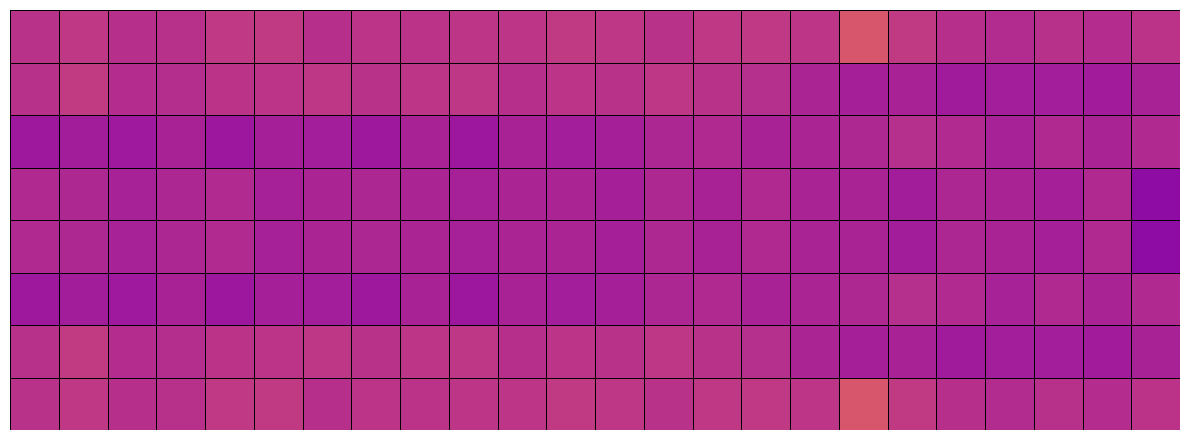

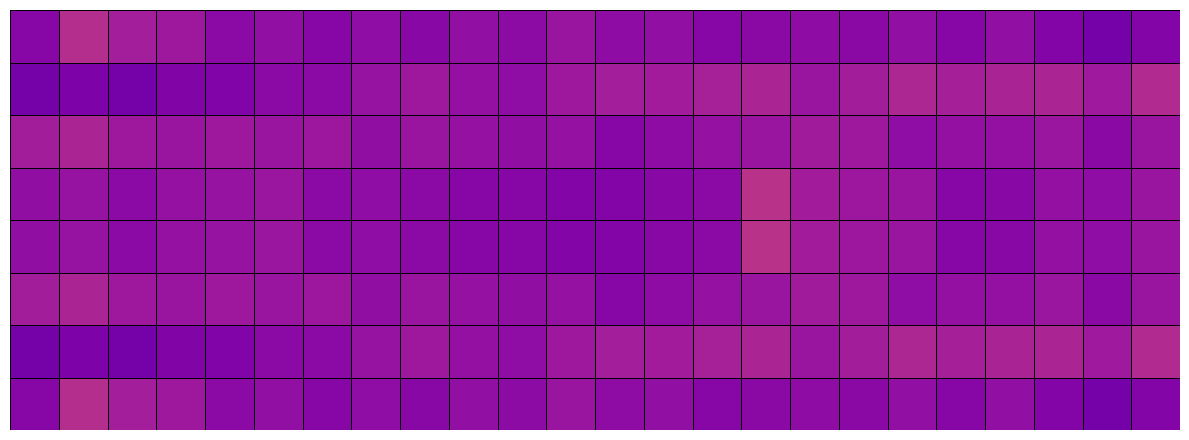

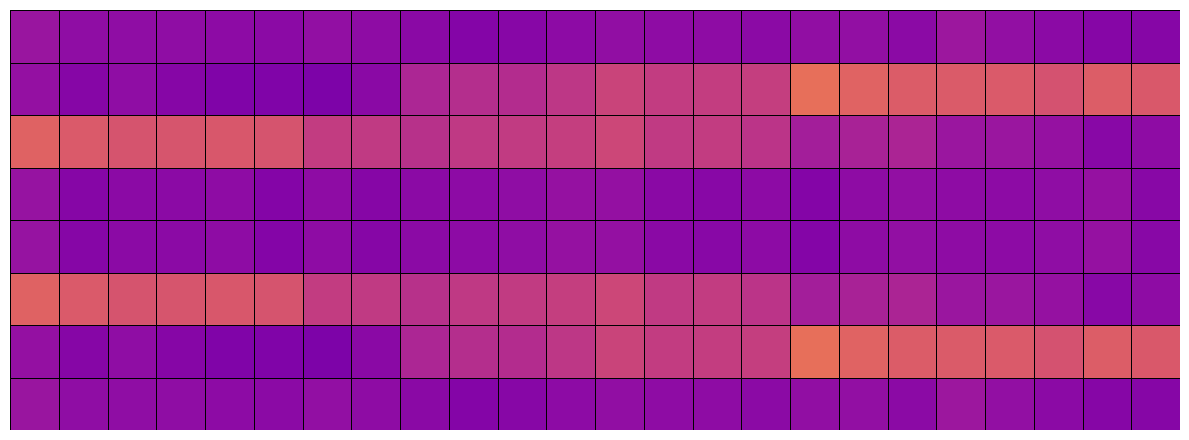

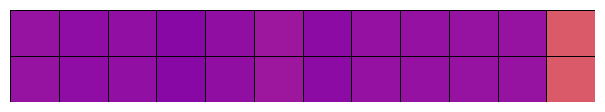

In [51]:
for i in range(3):
    plt.figure(figsize=(12, 4.5))
    sns.heatmap(X_train_b[0, :, :, i], vmax=1, vmin=0, linewidths=0.5, linecolor='black', cmap="plasma", cbar=False)
    plt.xticks([])  # Hide x-axis ticks
    plt.yticks([])  # Hide y-axis ticks
    plt.tight_layout()
    plt.savefig(f"channel{i+1}.png", dpi=1200)
    plt.show()

plt.figure(figsize=(7.55, 1.2))
plt.tight_layout()
sns.heatmap(y_train[0], vmax=1, vmin=0, linewidths=0.5, linecolor='black', cmap="plasma", cbar=False)
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.savefig(f"y.png", dpi=1200)
plt.show()

In [39]:
@register_keras_serializable('ECALayer')
class ECALayer(Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        c = input_shape[-1]
        self.t = max(1, int(abs((tf.math.log(float(c)) / tf.math.log(2.0) + self.b) / self.gamma)))
        self.conv = Conv1D(filters=1, kernel_size=self.t, padding='same', use_bias=False)
        super(ECALayer, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling over the spatial dimensions to produce a (batch_size, 1, channels) tensor
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, -1))(x)
        x = self.conv(x)
        x = sigmoid(x)
        x = tf.squeeze(x, axis=1)  # Squeeze to make it (batch_size, channels)
        
        # Multiply weights across channels
        return inputs * x[:, tf.newaxis, tf.newaxis, :]

    def get_config(self):
        config = super(ECALayer, self).get_config()
        config.update({
            'gamma': self.gamma,
            'b': self.b
        })
        return config

In [41]:
model = load_model(
    "./model/image_inpainting_CNN_LSTM_3days.keras",
    custom_objects={
        "ECALayer": ECALayer
    },
    compile=False
)

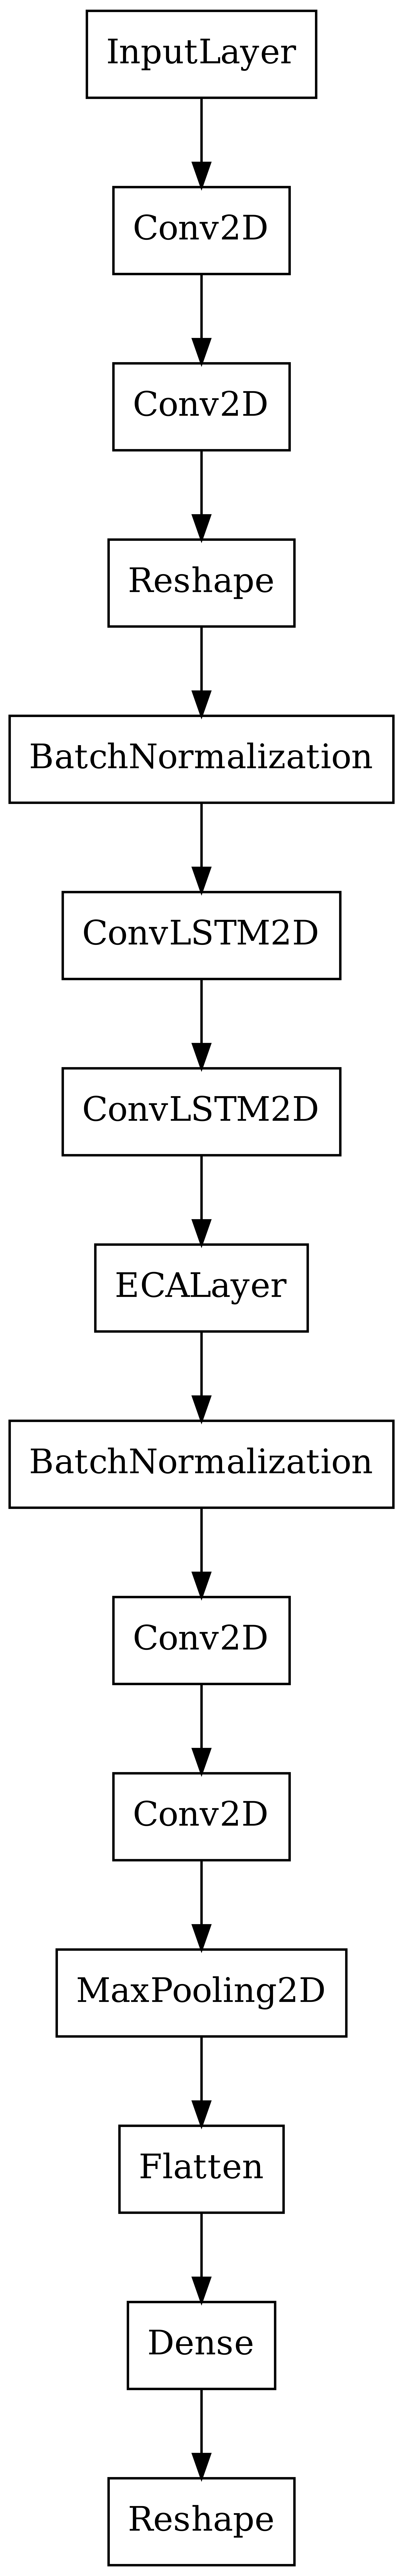

In [55]:
plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=1200,
    show_layer_activations=False,
    show_trainable=False,
)

In [46]:

y_pred = model.predict([X_test_b])


2024-05-06 06:31:24.268589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/Tanh_1' -> 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/mul_5', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/mul_2' -> 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/add_5', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/convolution_7' -> 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/add_6'}.
2024-05-06 06:31:24.327859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


144/144 [==============================] - 1s 4ms/step


In [47]:

y_pred_final = y_pred.sum(axis=1)/2
y_test_final = y_test.sum(axis=1)/2
print(y_test_final.shape)
print(y_pred_final.shape)
mse = mean_squared_error(y_test_final, y_pred_final)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_final, y_pred_final)
r2 = r2_score(y_test_final, y_pred_final)
print("-" * 86)
print(f'mse: {mse:.4f}')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'r2: {r2:.4f}')
print("-" * 86)

(4608, 12)
(4608, 12)
--------------------------------------------------------------------------------------
mse: 0.0038
rmse: 0.0617
mae: 0.0417
r2: 0.8436
--------------------------------------------------------------------------------------


In [48]:
TEST_PLOT_DIR = "./test_plots/image_inpainting_nn/"

In [49]:
if not os.path.exists(TEST_PLOT_DIR):
    os.makedirs(TEST_PLOT_DIR)
if not os.path.exists("./model"):
    os.makedirs("./model")
if not os.path.exists("./training_history"):
    os.makedirs("./training_history")

In [50]:
pred_data = scaler.inverse_transform(y_pred_final)
actual_data = scaler.inverse_transform(y_test_final)
previous_data = scaler.inverse_transform(X_test_b_flatten)
for i in range(actual_data.shape[0]):
    plt.figure(figsize=(12, 6))
    X1 = np.concatenate((X_test_b_timestamp[i][-30:], y_test_timestamp[i]))
    y1 = np.concatenate((previous_data[i][-30:], actual_data[i]))
    X2 = y_test_timestamp[i]
    y_p = pred_data[i]
    y_a = actual_data[i]
    Xh = np.full(100, X1[len(X1)-12])
    yh = np.arange(0, 100, 1)
    plt.title(f"Time Series {i+1} prediction")
    plt.plot(X1, y1, '--', color='#98afc7')
    plt.plot(X2, y_p, label='Predict')
    plt.plot(X2, y_a, label='Actual')
    plt.scatter(X2, y_p)
    plt.scatter(X2, y_a)
    plt.plot(Xh, yh, color='#4863a0', alpha=0.5)
    plt.ylim(0, 100)
    plt.xlabel('Time step')
    plt.ylabel('Usage (kWh)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(TEST_PLOT_DIR+f"Time_Series_{i+1}.png")
    plt.close()